In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import pickle
from my_functions import (load_data, preprocess_data, 
    plotting_confusion_matrix, get_features,
    calculating_marketing_campaighn,
)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, make_scorer, f1_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt


In [26]:
# Load and preprocess your data as before
train_data = preprocess_data(load_data('data/churn_train_data.pcl'))
_, features, _  = load_data('CatBoostClassifier_26062025_07_17.pickle')
train_data.shape

(150000, 768)

In [27]:

y = train_data['target']
X = train_data[features]
print('target shape', y.shape)
print('train data shape', X.shape)

# Split data FIRST
X_tr, X_te, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
)

# Fit scaler ONLY on X_train
scaler = StandardScaler()
scaler.fit(X_tr)
X_train_scaled = pd.DataFrame(scaler.transform(X_tr), index=X_tr.index, columns=X_tr.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_te), index=X_te.index, columns=X_te.columns)

# Fit Isolation Forest ONLY on X_train_scaled
iso = IsolationForest(n_estimators=200, contamination=0.3, random_state=42)
iso.fit(X_train_scaled)

# Compute iso_score for both splits (flip sign so higher = more anomalous)
X_train = X_tr.copy()
X_test = X_te.copy()

X_train['iso_score'] = -iso.decision_function(X_train_scaled)
X_test['iso_score'] = -iso.decision_function(X_test_scaled)

distribution = lambda s: {k: float(f'{v:.4f}') for k, v in s.value_counts(normalize=True).to_dict().items()}
print(f"Train target class distribution: {distribution(y_train)}")
print(f"Test target class distribution: {distribution(y_test)}")

target shape (150000,)
train data shape (150000, 315)
Train target class distribution: {0.0: 0.9362, 1.0: 0.0638}
Test target class distribution: {0.0: 0.9355, 1.0: 0.0645}


In [28]:
# Train CatBoost with early stopping
model = CatBoostClassifier(
    auto_class_weights='Balanced',
    eval_metric='F1',
    iterations=500,
    learning_rate=0.07,
    verbose=50,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    plot=True,
    use_best_model=True,
    early_stopping_rounds=50
)

# 8. Evaluate
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred_proba))


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7659104	test: 0.7750095	best: 0.7750095 (0)	total: 90.6ms	remaining: 45.2s
50:	learn: 0.8146812	test: 0.8116007	best: 0.8119440 (48)	total: 1.53s	remaining: 13.5s
100:	learn: 0.8251886	test: 0.8188054	best: 0.8191051 (94)	total: 2.82s	remaining: 11.2s
150:	learn: 0.8336052	test: 0.8211995	best: 0.8215421 (139)	total: 4.17s	remaining: 9.63s
200:	learn: 0.8451732	test: 0.8245561	best: 0.8254297 (192)	total: 5.69s	remaining: 8.46s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.825429737
bestIteration = 192

Shrink model to first 193 iterations.
              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91     28065
         1.0       0.27      0.81      0.41      1935

    accuracy                           0.85     30000
   macro avg       0.63      0.83      0.66     30000
weighted avg       0.94      0.85      0.88     30000

ROC AUC: 0.8991737619065375


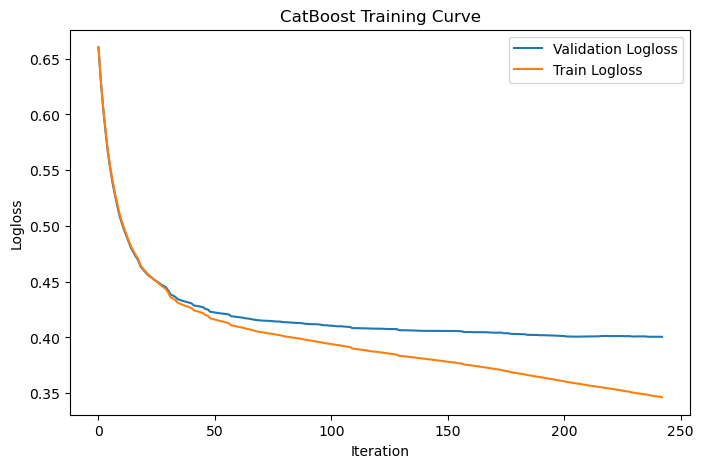

In [30]:
evals_result = model.get_evals_result()
plt.figure(figsize=(8,5))
plt.plot(evals_result['validation']['Logloss'], label='Validation Logloss')
plt.plot(evals_result['learn']['Logloss'], label='Train Logloss')
plt.xlabel('Iteration')
plt.ylabel('Logloss')
plt.title('CatBoost Training Curve')
plt.legend()
plt.show()

Generating confusion matrix...


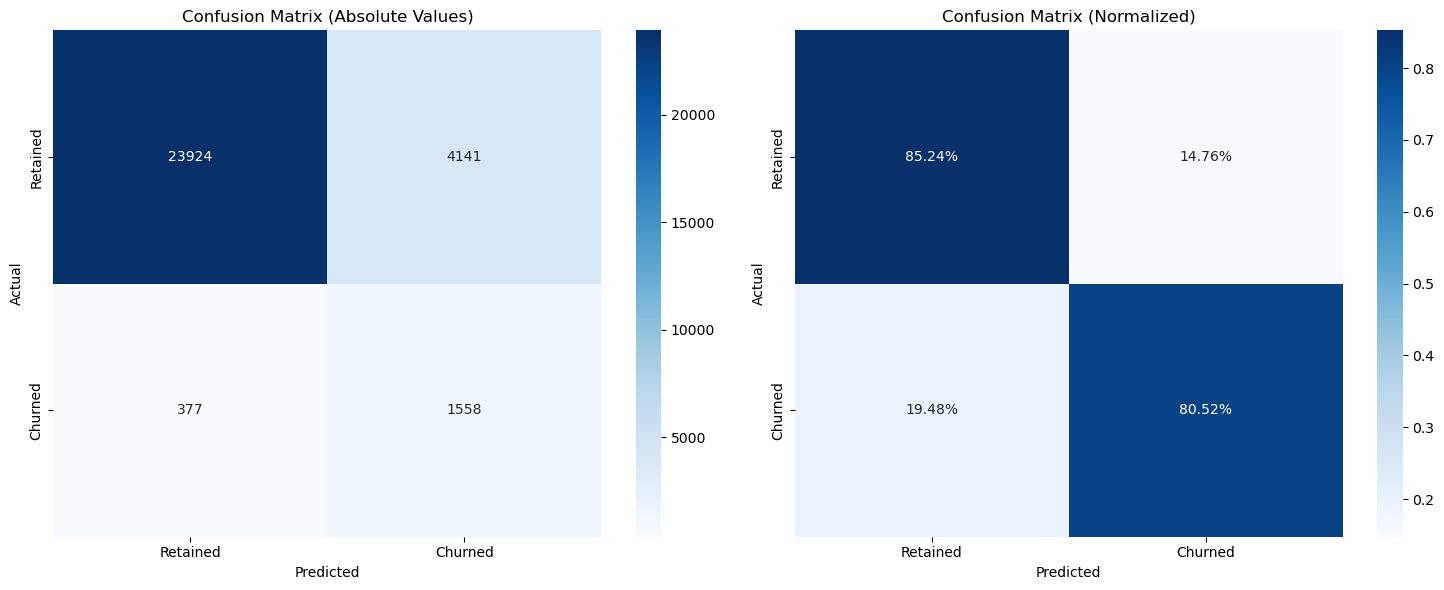


Business Impact Analysis:

True Negatives (Correctly identified retained): 23,924
False Positives (Incorrectly flagged as churn): 4,141
False Negatives (Missed churners): 377
True Positives (Correctly identified churn): 1,558
Confusion matrix analysis completed!


In [32]:
plotting_confusion_matrix(y_test, y_pred)

    metric = F1
    l_rate = 0.07
    True Negatives (Correctly identified retained): 23,924
    False Positives (Incorrectly flagged as churn): 4,141
    False Negatives (Missed churners): 377
    True Positives (Correctly identified churn): 1,558


Top 20 Features:
                     Feature  Importance
0           loc_market_share   12.516969
1      num_act_days_mea_mnt3    4.079307
2          device_type_modem    3.878150
3          device_days_usage    3.082220
4          device_brand_sony    2.638213
5      num_act_days_mea_mnt1    2.258891
6                         lt    2.201594
7          loc_is_obl_center    2.002266
8                  iso_score    1.645260
9          device_type_phone    1.617112
10               Balance_uah    1.474812
11          all_cnt_std_mnt3    1.232584
12  voice_in_td_cnt_min_mnt1    1.161454
13          all_cnt_min_mnt3    1.132378
14          all_cnt_std_mnt1    1.128634
15       sms_in_cnt_max_mnt3    1.108323
16                active_ppm    1.042751
17           device_type_nan    0.982325
18        device_brand_other    0.971894
19                 last_paym    0.846821

Number of Features with Importance > 0.0: 289


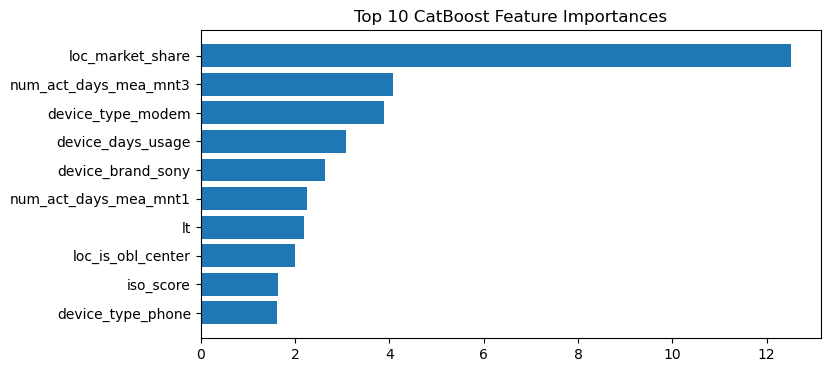

In [34]:
_, features_with_importance_gt_zero = get_features(model, X_train, y_train, top_n=20)

# Feature importance: CatBoost
catboost_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.get_feature_importance()
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 4))
plt.barh(features_with_importance_gt_zero['Feature'].head(10), features_with_importance_gt_zero['Importance'].head(10))
plt.gca().invert_yaxis()
plt.title('Top 10 CatBoost Feature Importances')
plt.show()


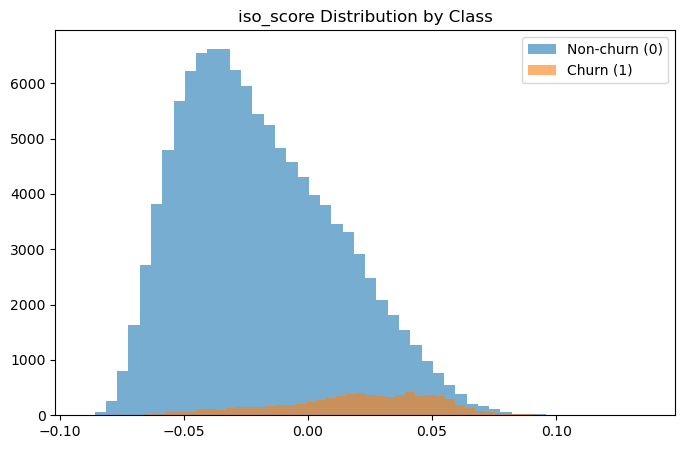

In [35]:
plt.figure(figsize=(8,5))
plt.hist(X_train['iso_score'][y_train == 0], bins=50, alpha=0.6, label='Non-churn (0)')
plt.hist(X_train['iso_score'][y_train == 1], bins=50, alpha=0.6, label='Churn (1)')
plt.legend()
plt.title('iso_score Distribution by Class')
plt.show()


Analysis of the iso_score Distribution

Both classes (Non-churn and Churn) occupy almost identical value ranges of iso_score.
- Churners (1) do not have a distinct cluster at lower or higher values—their distribution almost fully overlaps with the majority (Non-churn, 0).
- The Churn (brown) histogram is just a tiny shadow under the much larger Non-churn curve; there’s no visible region where churners dominate.

What This Means:
- iso_score contains almost zero signal to differentiate churners from non-churners.


Finding optimal decision threshold...
Optimal threshold value: 0.76
Maximum F1 Score: 0.51


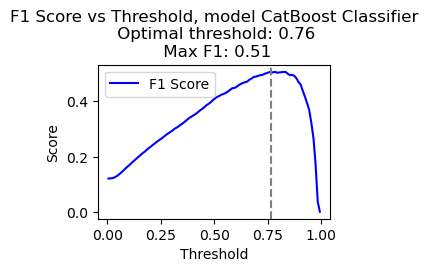

Date and time:  2025-06-26 10:17:28
Threshold optimization completed!


In [37]:
print("Finding optimal decision threshold...")
from my_functions import calculate_optimal_threshold
# Get test predictions for threshold optimization

# Find optimal threshold on test set (better: use validation set in real projects)
optimal_threshold, max_f1 = calculate_optimal_threshold(y_test, y_pred_proba)

# Apply optimal threshold to test probabilities to get binary predictions
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

print("Threshold optimization completed!")

Generating confusion matrix...


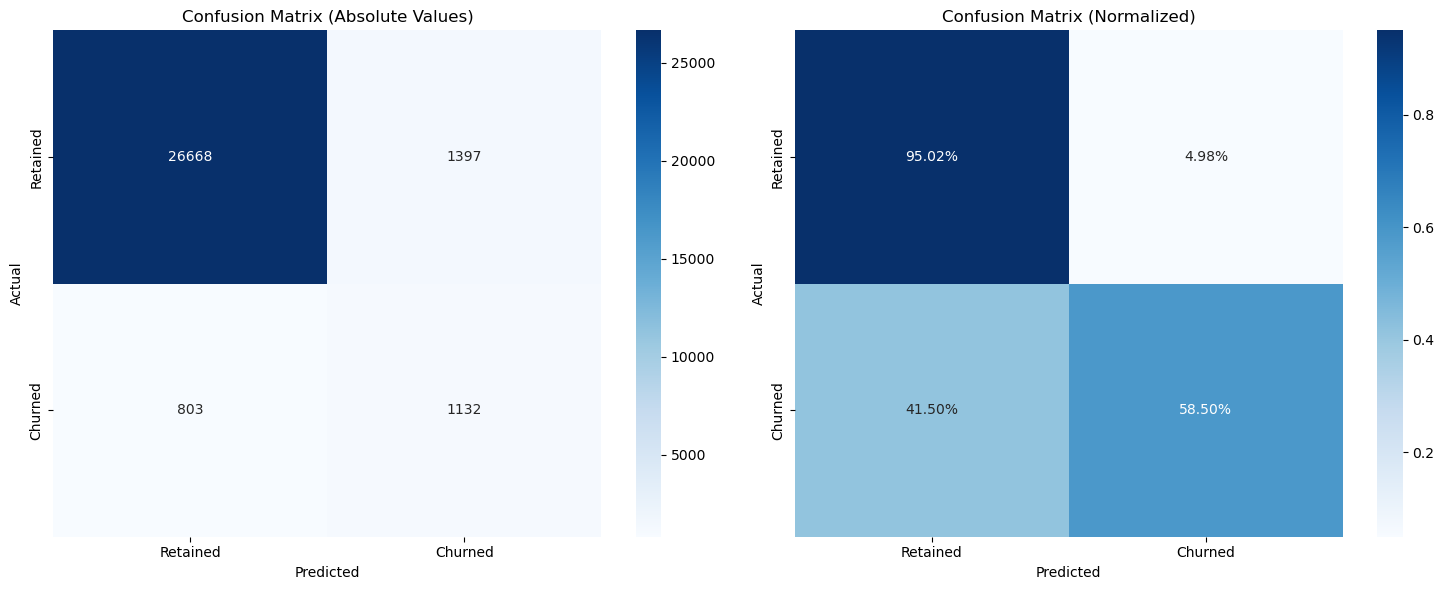


Business Impact Analysis:

True Negatives (Correctly identified retained): 26,668
False Positives (Incorrectly flagged as churn): 1,397
False Negatives (Missed churners): 803
True Positives (Correctly identified churn): 1,132
Confusion matrix analysis completed!


In [38]:
plotting_confusion_matrix(y_test, y_pred_optimal)

TRADE-OFF between sensibility and precision

In [40]:
# Define the stratified splitter
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define your model
cat = CatBoostClassifier(iterations=195, learning_rate= 0.07, verbose=0, random_seed=42)

# Use F1 as the scoring metric
scorer = make_scorer(f1_score)

# Perform cross-validation
scores = cross_val_score(cat, X, y, cv=skf, scoring=scorer)

print("F1 scores for each fold:", scores)
print("Average F1 score:", scores.mean())

F1 scores for each fold: [0.40014959 0.42132165 0.43529412 0.42242019 0.432531  ]
Average F1 score: 0.42234330976155404


In [41]:
y = train_data['target']
X_scaled = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)
iso.fit(X_scaled)
X_final_train = X.copy()
X_final_train['iso_score'] = -iso.decision_function(X_scaled)


In [50]:
# Train final optimized model
print("Training tuned model...")
final_model = CatBoostClassifier(auto_class_weights='Balanced', 
                                 eval_metric='AUC',
                                 iterations=195,
                                 verbose=50, 
                                 random_seed=42)

final_model.fit(X_final_train, y, early_stopping_rounds=50)
print("Final model training completed!")

Training tuned model...
Learning rate set to 0.391889
0:	total: 31.4ms	remaining: 6.1s
50:	total: 1.47s	remaining: 4.14s
100:	total: 2.86s	remaining: 2.66s
150:	total: 4.35s	remaining: 1.27s
194:	total: 5.71s	remaining: 0us
Final model training completed!


In [52]:
# Load test data
test = load_data('data/churn_test_model_fe.pickle')
print("Test data structure:")
print(f"Dataset shape: {test.shape}")

Test data structure:
Dataset shape: (150000, 817)


In [54]:
# Do the same transformation as with train data
df_test = test[features].fillna(-1)
y = test['target']
X = df_test
X_scaled = pd.DataFrame(scaler.transform(df_test), index=df_test.index, columns=df_test.columns)
iso.fit(X_scaled)
X_test = X.copy()
X_test['iso_score'] = -iso.decision_function(X_scaled)


In [56]:
# Predict
predictions_proba = final_model.predict_proba(X_test)[:, 1]
predictions_proba

array([0.09169434, 0.02687977, 0.00492873, ..., 0.31815938, 0.35233475,
       0.97658898])

In [57]:
# Evaluate
predictions = final_model.predict(X_test)

print(classification_report(y, predictions))
print('ROC AUC:', roc_auc_score(y, predictions_proba))


              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93    140597
         1.0       0.30      0.72      0.42      9403

    accuracy                           0.88    150000
   macro avg       0.64      0.80      0.68    150000
weighted avg       0.94      0.88      0.90    150000

ROC AUC: 0.8799672640088008


Generating confusion matrix...


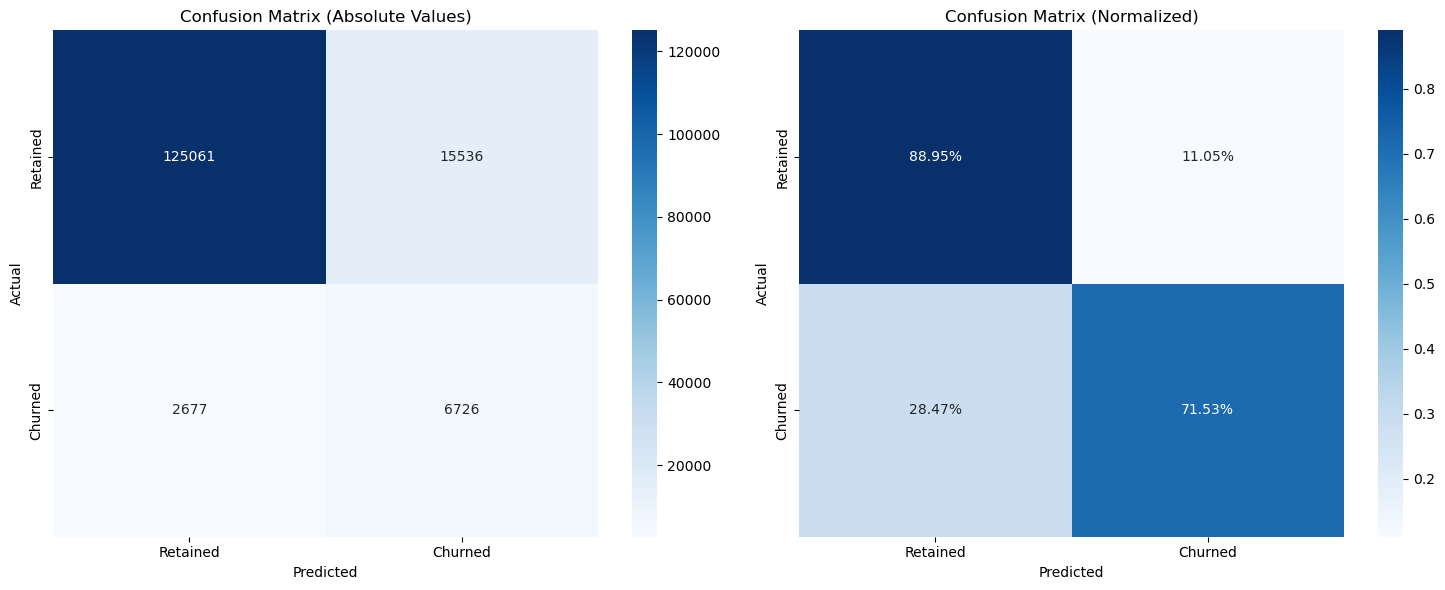


Business Impact Analysis:

True Negatives (Correctly identified retained): 125,061
False Positives (Incorrectly flagged as churn): 15,536
False Negatives (Missed churners): 2,677
True Positives (Correctly identified churn): 6,726
Confusion matrix analysis completed!


In [58]:
plotting_confusion_matrix(y, predictions)

In [61]:
# Calculating business impact and ROI potential for multiple retention scenarios.

roi_df = calculating_marketing_campaighn(y, predictions, avg_customer_value = 50, campaign_cost_per_customer = 20)

Calculating business impact and ROI potential for multiple retention scenarios...

Business Impact Analysis (Retention Scenarios):
Total customers in test set: 150,000
Actual churners: 9,403.0 (6.3%)
Predicted churners: 22,262.0 (14.8%)
Correctly identified churners: 6,726

Retention Rate (%)  Potential Savings ($)  Campaign Cost ($)  Net ROI ($)    ROI (%)
                3%               121068.0           445240.0    -324172.0 -72.808373
                5%               201780.0           445240.0    -243460.0 -54.680622
                6%               242136.0           445240.0    -203104.0 -45.616746
                7%               282492.0           445240.0    -162748.0 -36.552870
               10%               403560.0           445240.0     -41680.0  -9.361243
               15%               605340.0           445240.0     160100.0  35.958135
               20%               807120.0           445240.0     361880.0  81.277513
               25%              1008900.0    